In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import csv
import cv2
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
import os.path
import csv
%matplotlib inline

Using TensorFlow backend.


In [2]:
#batch size and epoch
batch_size=128
NB_EPOCH=1

In [3]:
samples = []
with open('./driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

#def image_preprocessing(img):
#    """preproccesing training data to keep only S channel in HSV color space, and resize to 16X32"""
#    resized = cv2.resize((cv2.cvtColor(img, cv2.COLOR_RGB2HSV))[:,:,1],(img_cols,img_rows))
#    return resized

#if K.image_data_format() == 'channels_first':
#    input_shape = (3, img_width, img_height)
#else:
#    input_shape = (img_width, img_height, 3)

from sklearn.cross_validation import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

import cv2
import numpy as np
import sklearn

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = './IMG/'+batch_sample[0].split('/')[-1]
                if os.path.isfile(name):
                    center_image = cv2.imread(name)
                    #center_image = cv2.resize((cv2.cvtColor(img, cv2.COLOR_RGB2HSV))[:,:,1],(32,16))
                    #center_image = cv2.resize(center_image, (0,0), fx=0.5, fy=0.5) 
                    center_angle = float(batch_sample[3])
                    images.append(center_image)
                    angles.append(center_angle)
             
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), strides=(2, 2), activation="relu")`
/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), strides=(2, 2), activation="relu")`
/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(2, 2), activation="relu")`
/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:38: U

Epoch 1/1
33828/33828 [==============================] - 14421s - loss: 0.0304 - val_loss: 0.0331


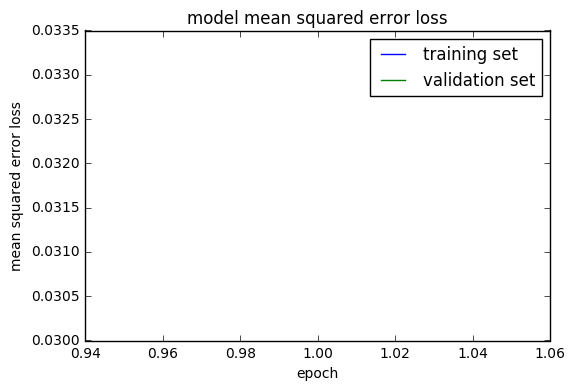

In [4]:
# build network
# Nvidia architecture
# see: https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/


#def myLambda(x):
#    from keras.backend import tf as ktf
#    return ktf.image.resize_images(x, (32, 64))

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160, 320, 3)))
#model.add(Lambda(lambda x: x, input_shape=(160, 320, 3)))
#model.add(Lambda(myLambda))
model.add(Cropping2D(cropping=((70, 25), (0, 0))))
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Dropout(0.25))
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Dropout(0.25))
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Dropout(0.25))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Dropout(0.25))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Dense(1))

# train model
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(
    train_generator, samples_per_epoch=len(train_samples)*3,
    validation_data=validation_generator, nb_val_samples=len(validation_samples)*3,
    nb_epoch=NB_EPOCH)

# plot training history
plot_x = np.arange(1, NB_EPOCH+1)
plt.plot(plot_x, history_object.history['loss'])
plt.plot(plot_x, history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig('training_history_dropout.png')

# save model
model.save('model.h5')